## Baseline Modeling

Author: Calvin Chan 

### Introduction
In this notebook, we will go over a few baseline models to test out our data. Instead of using the whole data set, we will only be working with a sample of it using a function in our `functions.py` file. We will preprocess our data as well using `ecg_cleaning.py`.

### Table of Contents
- [Data Import](#import)
- [Preprocessing](#preprocess)
- [Logistic Regression](#logreg)
- [Simple Neural Network](#ann)
- [SimpleNN w/ Full Data Set](#full)

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy

import load_functions as f
import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

%autosave 300

Autosaving every 300 seconds


<a id='import'></a>
### Sample Data Import

Let's load a sample of our data set and feed it into a Logistic Regression and a simple neural network.

In [2]:
# File path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Load sample data using high frequency
X_sample, y_sample = f.load_sample_signal(10000, path, metadata, random_state=42)

Below we have the option of reshaping our data if we wish to by flattening the 12 leads out. Otherwise we set Lead II as the signal we look at for all ECG signals.

In [3]:
# Reshaping 

# Flattening all 12 leads to be side by side
# X_sample = X_sample.reshape(100, -1)

# Only looking at Lead II
X_sample = X_sample[:,:,1]

X_sample.shape

(10000, 1000)

<a id='preprocess'></a>
### Data Preprocessing

Before we can feed our data into models, we need to do some preprocessing with it. This includes
- Label encoding 
- ECG denoising 
- Train/test split
- Binary classification

#### Label Encoding

First we need to change our labels in our target column to numerical values. We can do that using `LabelEncoder()`.

In [4]:
# Get our unique values first
y_unique = np.unique(y_sample)

In [5]:
# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y_sample)

# Transform target column 
y_sample_transformed = label.transform(y_sample)

In [6]:
# Print transformed labels for our target column
print(y_unique)
print(label.transform(y_unique))

["['CD', 'MI']" "['CD', 'NORM']" "['CD', 'STTC']" "['CD']" "['HYP']"
 "['MI']" "['NORM']" "['STTC', 'HYP']" "['STTC', 'MI']" "['STTC']"]
[0 1 2 3 4 5 6 7 8 9]


#### ECG denoising

Next, we need to use our functions from `ecg_cleaning.py` to denoise our signal. We are setting the baseline removal range to be between between $f \in \space[0.1, 1.5]$ Hz and the high frequency range removal to be $45$ Hz and above.

In [7]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal
signal_bl = pd.DataFrame(X_sample).apply(lambda x: c.baseline_removal(x, freq_start=0.1, freq_stop=1.5))
signal_pli = pd.DataFrame(signal_bl).apply(lambda x: c.high_freq_removal(x, freq_start=45))

Now we are ready to do the train-test split. We will use 80-20 for our training and testing data, making sure we have all our categories in both train and test set. 

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y_sample_transformed, test_size=0.2, stratify=y_sample_transformed, random_state=42)

Let's look into the unique target classes for our train and test sets. 

In [9]:
# Unique categories in train
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
# Unique categories in test
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We can plot a sample signal from our training set that we will be using for training. 

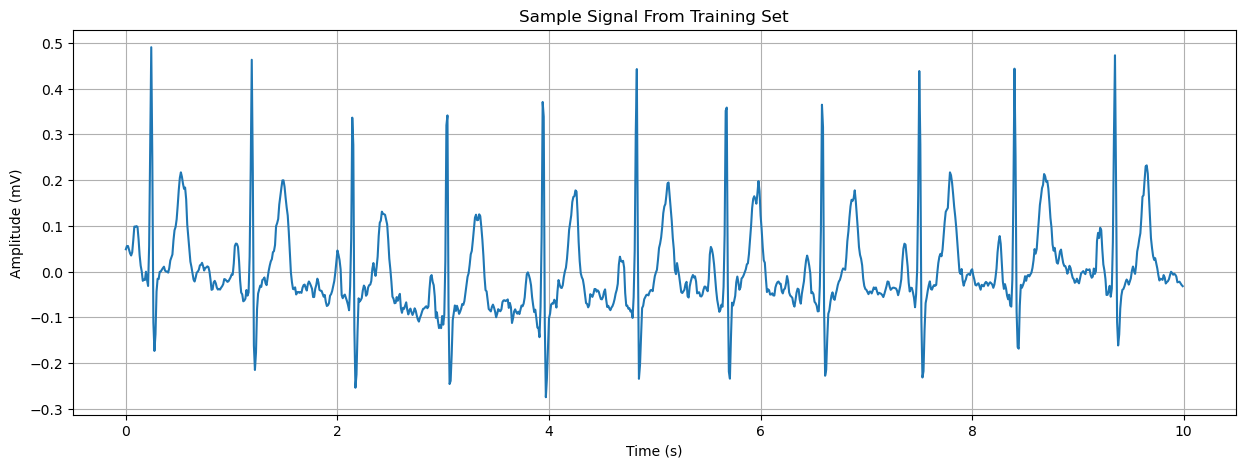

In [12]:
# Example signal
sig_len = X_sample.shape[1]
sampling_frequency = 100

# Set time axis
time = np.arange(0, sig_len) / sampling_frequency

# Plot a sample signal 
plt.figure(figsize=(15,5))
plt.plot(time, X_train.iloc[0,:]) # Plot first signal 
plt.title("Sample Signal From Training Set")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

<a id='logreg'></a>
### Logistic Regression

We are ready for modelling, starting with Logistic Regression. For this method we will splitting our data into bins based on the amplitude of the signal and try to classify different types of ECGs from how many counts are in each signal amplitude bin. Visually, this looks like the following 

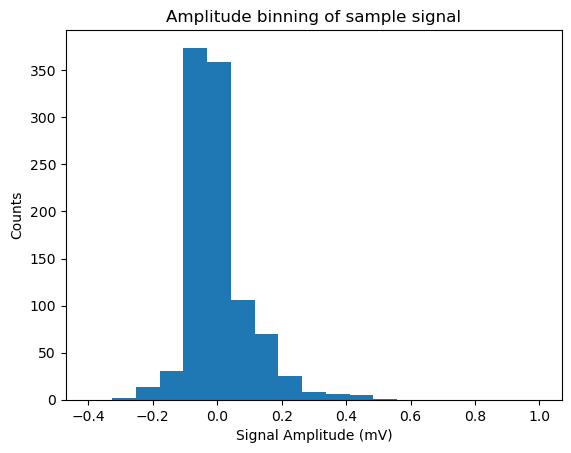

In [13]:
# Binning with the sample signal above
plt.hist(X_train.iloc[0,:], bins=np.linspace(-0.4, 1, 20))
plt.title("Amplitude binning of sample signal")
plt.xlabel("Signal Amplitude (mV)")
plt.ylabel("Counts")
plt.show()

In [14]:
# Counts in each bin for the sample signal amplitude
counts, bins = np.histogram(X_train.iloc[0,:], bins=np.linspace(-0.4, 1, 21))
counts

array([  0,   1,  14,  21, 231, 461, 126,  72,  50,   8,   9,   2,   5,
         0,   0,   0,   0,   0,   0,   0])

Now to generalize this for all signals in our train and test sets.

In [15]:
# Binning our signals by their amplitude
binned_X_train = X_train.apply(lambda x: np.histogram(x, bins=np.linspace(-0.4, 1, 21))[0], axis=1)
binned_X_test = X_test.apply(lambda x: np.histogram(x, bins=np.linspace(-0.4, 1, 21))[0], axis=1)

Since the binned signals are in a Pandas dataframe format, we need to convert it to a numpy array and reshape it to a suitable size for Logistic Regression. 

In [16]:
# Converting Pandas dataframe to numpy array and reshaping to (4000, 20) for training, (1000, 20) for testing
binned_X_train = np.array(binned_X_train.to_list()).reshape(8000, 20)
binned_X_test = np.array(binned_X_test.to_list()).reshape(2000, 20)

In [17]:
# Sanity check
binned_X_train.shape, binned_X_test.shape

((8000, 20), (2000, 20))

In [18]:
# Making sure our shapes are correct for modelling
y_train.shape, y_test.shape

((8000,), (2000,))

Now we can feed our data into the logistic regression model. We can do this in one cell by instantiating the model, fitting it to our training set and scoring the training set as well as the testing set. 

In [19]:
# Instantiate model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit model
logreg.fit(binned_X_train, y_train)

# Score
print(f"Training score: {logreg.score(binned_X_train, y_train)}")
print(f"Testing score: {logreg.score(binned_X_test, y_test)}")

Training score: 0.52
Testing score: 0.517


/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| Model  | Classification | Train Accuracy | Test Accuracy |
|--------|----------------|----------------|---------------|
| LogReg | Multiclass     | 52.0           | 51.7          |

As we can see with the scoring Logistic Regression does not do well with our data. This is expected as the signals we are dealing with 10 classes in total. Due to major class imbalance, some classes are not being classified. We can see this by doing a prediction of our training set using our model and compare it with the true labels through a classification report. 

In [20]:
# Predict our training and testing set 
y_pred_train = logreg.predict(binned_X_train)
y_pred_test = logreg.predict(binned_X_test)

In [21]:
# Classification report
cr = classification_report(y_train, y_pred_train)
print("Multiclass training classification report:")
print(cr)
cr = classification_report(y_test, y_pred_test)
print("Multiclass testing classification report:")
print(cr)

Multiclass training classification report:
              precision    recall  f1-score   support

           0       0.38      0.09      0.15       292
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00       162
           3       0.41      0.31      0.35      1363
           4       0.00      0.00      0.00        95
           5       0.32      0.07      0.12       727
           6       0.58      0.89      0.70      3608
           7       0.44      0.11      0.17       227
           8       0.00      0.00      0.00       125
           9       0.37      0.31      0.33      1351

    accuracy                           0.52      8000
   macro avg       0.25      0.18      0.18      8000
weighted avg       0.45      0.52      0.45      8000

Multiclass testing classification report:
              precision    recall  f1-score   support

           0       0.33      0.07      0.11        73
           1       0.00      0.00      0.00    

/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

From the report, we can see that with very little data for certain classes, they are not being classified by the model into their own classes causing a precision, recall, and f1-score of zero. Meaning this model is not good at performing classification for our 10 diagnostic superclasses. 

#### Binary Classification

Let's give Logistic Regression one more try by doing binary classification instead of multiclass classification. We can do this by converting labels marked only as `NORM` to be normal ECGs and everything else as `ABNO`. We created a function in our `load_functions.py` that does that. 

In [22]:
y_sample_binary = np.array(list(map(f.binary, y_sample)))

In [23]:
y_binary_unique = np.unique(y_sample_binary)

In [24]:
# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y_sample_binary)

# Transform target column 
y_sample_binary = label.transform(y_sample_binary)

In [25]:
# Print transformed labels for our target column
print(f"Our binary labels are {y_binary_unique}")
print(f"They are labeled as follows {label.transform(y_binary_unique)}")

Our binary labels are ['ABNO' 'NORM']
They are labeled as follows [0 1]


In [26]:
# Train test split
X_train, X_test, y_train_binary, y_test_binary = train_test_split(signal_pli, y_sample_binary, test_size=0.2, stratify=y_sample_binary, random_state=42)

In [27]:
# Binning our signals by their amplitude
binned_X_train = X_train.apply(lambda x: np.histogram(x, bins=np.linspace(-0.4, 1, 21))[0], axis=1)
binned_X_test = X_test.apply(lambda x: np.histogram(x, bins=np.linspace(-0.4, 1, 21))[0], axis=1)

Since the binned signals are in a Pandas dataframe format, we need to convert it to a numpy array and reshape it to a suitable size for Logistic Regression. 

In [28]:
# Converting Pandas dataframe to numpy array and reshaping to (4000, 20) for training, (1000, 20) for testing
binned_X_train = np.array(binned_X_train.to_list()).reshape(8000, 20)
binned_X_test = np.array(binned_X_test.to_list()).reshape(2000, 20)

In [29]:
# Sanity check
binned_X_train.shape, binned_X_test.shape

((8000, 20), (2000, 20))

In [30]:
# Making sure our shapes are correct for modelling
y_train_binary.shape, y_test_binary.shape

((8000,), (2000,))

Now we can feed our data into the logistic regression model. We can do this in one cell by instantiating the model, fitting it to our training set and scoring the training set as well as the testing set. 

In [31]:
# Instantiate model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit model
logreg.fit(binned_X_train, y_train_binary)

# Score
print(f"Training score: {logreg.score(binned_X_train, y_train_binary)}")
print(f"Testing score: {logreg.score(binned_X_test, y_test_binary)}")

Training score: 0.694375
Testing score: 0.7075


/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| Model  | Classification | Train Accuracy | Test Accuracy |
|--------|----------------|----------------|---------------|
| LogReg | Multiclass     | 52.0           | 51.7          |
| LogReg | Binary         | 69.4           | 70.8          |

As we expect, Logistic Regression performs a lot better for binary classification. Let's look at the classification report for the test set this time.  

In [32]:
# Predict our training and testing set 
y_pred_train = logreg.predict(binned_X_train)
y_pred_test = logreg.predict(binned_X_test)

In [33]:
# Classification report
cr = classification_report(y_train_binary, y_pred_train)
print("Binary training classification report:")
print(cr)
cr = classification_report(y_test_binary, y_pred_test)
print("Binary testing classification report:")
print(cr)

Binary training classification report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      4392
           1       0.67      0.63      0.65      3608

    accuracy                           0.69      8000
   macro avg       0.69      0.69      0.69      8000
weighted avg       0.69      0.69      0.69      8000

Binary testing classification report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1098
           1       0.69      0.63      0.66       902

    accuracy                           0.71      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.71      0.71      2000



We see that even with only 2000 sample points, because its only binary classification, the class imbalance is much smaller, leading to positive results in accuracy. We also see that since we have more sample points for class `ABNO`, the recall score for it is much higher than for `NORM`. This is good because as an ECG classifying, we want to flag any possibility for abnormal heart rhythms, which is what having a high recall score does exactly. 

<a id='ann'></a>
### Simple Neural Network Classifier
Now we will try something more complicated. Let's build a simple neural network classifier to test out how it behaves on our sample data. We will be using the Keras API in TensorFlow, first let's set a seeding so we can always get the same results.

In [34]:
import random

def set_random_seed(seed):
    """Random seeds for reproducability"""
    
    random.seed(seed)
    tf.random.set_seed(seed)

In [35]:
set_random_seed(42)

We will start off with the multiclass classification again before trying binary classification. This means that we need to use a softmax activation function for our output layer with 10 nodes for the respective diagnostic superclasses. `SparseCategoricalCrossentropy` also needs to be used along with the respective accuracy metric. 

In [36]:
# Instantiate Neural Network 
model = Sequential()

# Add hidden layers
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(15, activation='relu'))

# Output layers
model.add(layers.Dense(10, activation='softmax')) # Since we have 10 classes, we need softmax for probability

# Compile our model with an optimizer, loss function and metric to look at
model.compile(
    # Optimizer
    optimizer=Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[SparseCategoricalAccuracy()]
)

2024-04-14 19:04:49.973439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using the same data we defined above, we do not need to redo our train test splits, we can fit the model on multiclass as well as binary classification following the binning method. Let's do multiclass first. 

In [37]:
# Fit our model, adding a validation set as well 
history = model.fit(binned_X_train, 
                    y_train, 
                    epochs=30, 
                    verbose=2, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                             verbose=1, 
                                                             restore_best_weights=True,
                                                             patience=3)])

Epoch 1/30
225/225 - 1s - loss: 3.7104 - sparse_categorical_accuracy: 0.3840 - val_loss: 1.6511 - val_sparse_categorical_accuracy: 0.4663 - 900ms/epoch - 4ms/step
Epoch 2/30
225/225 - 0s - loss: 1.6582 - sparse_categorical_accuracy: 0.4490 - val_loss: 1.5694 - val_sparse_categorical_accuracy: 0.4663 - 286ms/epoch - 1ms/step
Epoch 3/30
225/225 - 0s - loss: 1.6376 - sparse_categorical_accuracy: 0.4496 - val_loss: 1.5648 - val_sparse_categorical_accuracy: 0.4663 - 302ms/epoch - 1ms/step
Epoch 4/30
225/225 - 0s - loss: 1.6375 - sparse_categorical_accuracy: 0.4496 - val_loss: 1.5650 - val_sparse_categorical_accuracy: 0.4663 - 234ms/epoch - 1ms/step
Epoch 5/30
225/225 - 0s - loss: 1.6369 - sparse_categorical_accuracy: 0.4496 - val_loss: 1.5643 - val_sparse_categorical_accuracy: 0.4663 - 264ms/epoch - 1ms/step
Epoch 6/30
225/225 - 0s - loss: 1.6363 - sparse_categorical_accuracy: 0.4496 - val_loss: 1.5625 - val_sparse_categorical_accuracy: 0.4663 - 262ms/epoch - 1ms/step
Epoch 7/30
225/225 - 0

In [38]:
# Looking at our model parameters 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 20)                  420       
                                                                 
 dense_1 (Dense)             (32, 15)                  315       
                                                                 
 dense_2 (Dense)             (32, 10)                  160       
                                                                 
Total params: 895
Trainable params: 895
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][np.argmax(history.history["sparse_categorical_accuracy"])]
result = model.evaluate(binned_X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.4497
Test Accuracy: 0.4510


| Model    | Classification | Train Accuracy | Test Accuracy |
|----------|----------------|----------------|---------------|
| LogReg   | Multiclass     | 52.0           | 51.7          |
| LogReg   | Binary         | 69.4           | 70.8          |
| SimpleNN | Multiclass     | 44.9           | 45.1          |

As we can see from the accuracy scores, the neural network is not performing well for multiclass classification, this is possibly due to the limited amount of data we are feeding our network as neural networks generally perform better with mass amounts of data. 

Let's plot out our models loss function between the train and validation data. 

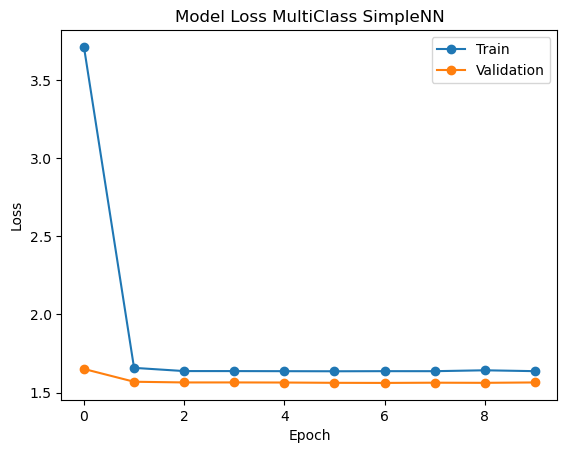

In [47]:
# Plotting loss function 
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss MultiClass SimpleNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

As we can see from the plot, the model the training loss decreases significantly in the first epoch and then plateaus. The validation set decreases very slightly before plateauing as well, meaning the model is not able to train effectively. 

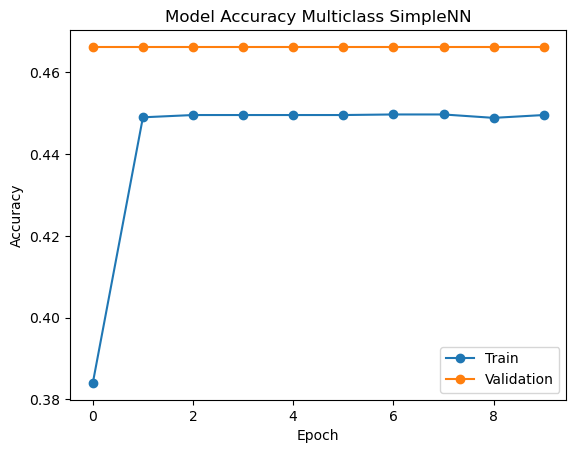

In [48]:
# Plotting accuracy function 
plt.plot(history.history['sparse_categorical_accuracy'], marker='o')
plt.plot(history.history['val_sparse_categorical_accuracy'], marker='o')
plt.title('Model Accuracy Multiclass SimpleNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

The accuracy scores for multiclass seem to be very low in general. This is reasonable as we have a major class imbalance. We see that training accuracy only increase in the first epoch and then does not really change in the rest. Validation accuracy does not change at all. Let's get the classification report for our multiclass model. 

In [58]:
# Get predicted target values for training and test set
y_pred_train = np.argmax(model.predict(binned_X_train), axis=1)
y_pred_test = np.argmax(model.predict(binned_X_test), axis=1)

In [59]:
# Classification report
cr = classification_report(y_train, y_pred_train)
print("Multiclass training classification report:")
print(cr)
cr = classification_report(y_test, y_pred_test)
print("Multiclass testing classification report:")
print(cr)

Multiclass training classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00       162
           3       1.00      0.00      0.00      1363
           4       0.00      0.00      0.00        95
           5       1.00      0.00      0.00       727
           6       0.45      1.00      0.62      3608
           7       0.00      0.00      0.00       227
           8       0.00      0.00      0.00       125
           9       0.00      0.00      0.00      1351

    accuracy                           0.45      8000
   macro avg       0.25      0.10      0.06      8000
weighted avg       0.46      0.45      0.28      8000

Multiclass testing classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.00      0.00      0.00    

/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Again, we see basically the same thing happening to here as with the Logistic Regression model where due to major class imbalance, most classes with lower sample data are essentially not predicted by the model causing the precision, recall, and f1-scores to be zero. 

#### Binary classification

We can redo the model again on binary classification using the binary variables we defined above. Note that we need to change some parameters in our simple neural network:
- **Output layer**: 10 -> 1
- **Output activation**: `softmax` -> `sigmoid`
- **Loss**: `SparseCategoricalCrossentropy` -> `BinaryCrossentropy`
- **Metric**: `SparseCategoricalAccuracy` -> `BinaryAccuracy`

We will also adjust the hidden layer node number from 15 to 10.  

In [74]:
set_random_seed(42)

In [75]:
# Instantiate Neural Network 
model2 = Sequential()

# Add hidden layers
model2.add(layers.Dense(20, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))

# Output layers
model2.add(layers.Dense(1, activation='sigmoid'))

# Compile our model with an optimizer, loss function and metric to look at
model2.compile(
    # Optimizer
    optimizer=Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[BinaryAccuracy()]
)

In [76]:
# Fit our model, adding a validation set as well 
history = model2.fit(binned_X_train, 
                    y_train_binary, 
                    epochs=30, 
                    verbose=2, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                             verbose=1, 
                                                             restore_best_weights=True,
                                                             patience=3)])

Epoch 1/30
225/225 - 1s - loss: 2.9180 - binary_accuracy: 0.6343 - val_loss: 0.6203 - val_binary_accuracy: 0.6675 - 868ms/epoch - 4ms/step
Epoch 2/30
225/225 - 0s - loss: 0.5679 - binary_accuracy: 0.7103 - val_loss: 0.5923 - val_binary_accuracy: 0.6913 - 410ms/epoch - 2ms/step
Epoch 3/30
225/225 - 0s - loss: 0.5567 - binary_accuracy: 0.7172 - val_loss: 0.5903 - val_binary_accuracy: 0.6762 - 305ms/epoch - 1ms/step
Epoch 4/30
225/225 - 0s - loss: 0.5421 - binary_accuracy: 0.7282 - val_loss: 0.5466 - val_binary_accuracy: 0.7300 - 328ms/epoch - 1ms/step
Epoch 5/30
225/225 - 0s - loss: 0.5404 - binary_accuracy: 0.7261 - val_loss: 0.5432 - val_binary_accuracy: 0.7337 - 309ms/epoch - 1ms/step
Epoch 6/30
225/225 - 0s - loss: 0.5356 - binary_accuracy: 0.7296 - val_loss: 0.5523 - val_binary_accuracy: 0.7088 - 341ms/epoch - 2ms/step
Epoch 7/30
225/225 - 0s - loss: 0.5305 - binary_accuracy: 0.7375 - val_loss: 0.5466 - val_binary_accuracy: 0.7350 - 335ms/epoch - 1ms/step
Epoch 8/30
Restoring model 

In [77]:
# Looking at our model parameters 
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (32, 20)                  420       
                                                                 
 dense_10 (Dense)            (32, 10)                  210       
                                                                 
 dense_11 (Dense)            (32, 1)                   11        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmax(history.history["binary_accuracy"])]
result = model2.evaluate(binned_X_test, y_test_binary, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.7407
Test Accuracy: 0.7360


| Model    | Classification | Train Accuracy | Test Accuracy |
|----------|----------------|----------------|---------------|
| LogReg   | Multiclass     | 52.0           | 51.7          |
| LogReg   | Binary         | 69.4           | 70.8          |
| SimpleNN | Multiclass     | 44.9           | 45.1          |
| SimpleNN | Binary         | 74.1           | 73.6          |

Looking at the training and testing scores for binary classification using the simple neural network, we actually see some decent scores. The neural network out performs Logistic Regression by a few percent which is a good sign. Let's plot out our models loss function between the train and validation data. 

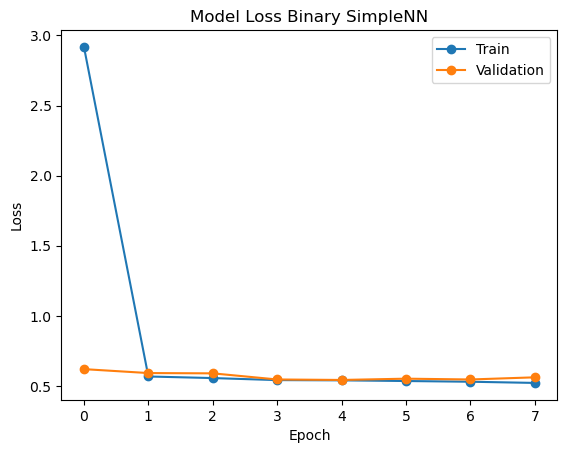

In [79]:
# Plotting loss function 
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss Binary SimpleNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

We can see that the behaviour is similar to the multiclass situation where the first epoch has the highest drop in training loss before plateauing and the validation loss having the smallest decrease in loss. Plotting the model accuracy, we have

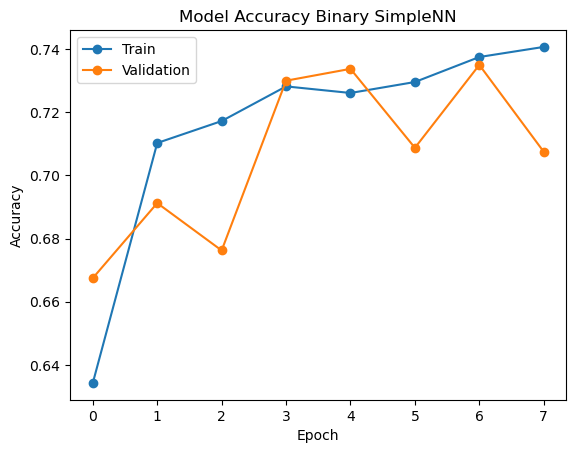

In [80]:
# Plotting accuracy function 
plt.plot(history.history['binary_accuracy'], marker='o')
plt.plot(history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy Binary SimpleNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

This plot is a lot better than what we had for the multiclass classification case. Although we still see fluctuations in the validation set, there is an overall trend of increasing accuracy. We can create a classification report for our binary classification using the simple neural network model. First, we need to get the predicted outcomes from our training and test set.

In [90]:
# Get predicted target for training and testing set
y_pred_train = (model2.predict(binned_X_train) > 0.5).astype(int).reshape(-1)
y_pred_test = (model2.predict(binned_X_test) > 0.5).astype(int).reshape(-1)

In [91]:
# Classification report
cr = classification_report(y_train_binary, y_pred_train)
print("Binary training classification report:")
print(cr)
cr = classification_report(y_test_binary, y_pred_test)
print("Binary testing classification report:")
print(cr)

Binary training classification report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      4392
           1       0.71      0.72      0.72      3608

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000

Binary testing classification report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1098
           1       0.71      0.70      0.70       902

    accuracy                           0.74      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.74      0.74      0.74      2000



Here we see better overall scores for our model when compared to the Logistic Regression case. We see that the precision and recall scores got pushed up which means that the simple neural network is able to identify differences between the binned amplitudes better. 

<a id='full'></a>
### Simple Neural Network With Full Data Set

Let's try to run our **full data set** on our binary classification simple neural network. Again we utilize the method of binning our ECG signals based on amplitude since it performs well. When we move on to advanced modelling, we will attempt to use the signal time samples themselves. 

First let's import our full data set using our function defined in `load_functions.py`.

In [169]:
# Import data
X, y = f.load_signal(path, metadata)

In [170]:
# Data shape
X.shape, y.shape

((15677, 1000, 12), (15677,))

In [171]:
# Only looking at Lead II

X = X[:,:,1]

X.shape, y.shape

((15677, 1000), (15677,))

We preprocess the data using our functions in `ecg_cleaning.py`.

In [172]:
# Baseline and PLI removal

signal_bl = np.apply_along_axis(c.baseline_removal, axis=1, arr=X, freq_start=0.1, freq_stop=1.5)
signal_pli = np.apply_along_axis(c.high_freq_removal, axis=1, arr=signal_bl, freq_start=40)

Let's plot a sample signal from our data set. 

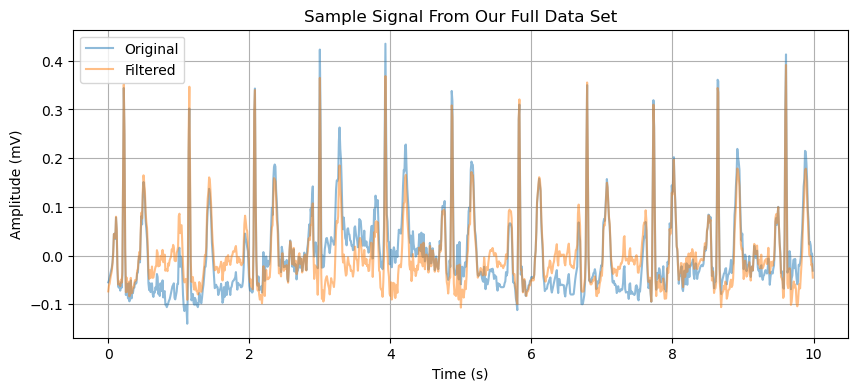

In [173]:
plt.figure(figsize=(10, 4))
plt.plot(time, np.real(X[0, :]), alpha=0.5, label="Original")
plt.plot(time, np.real(signal_pli[0, :]), alpha=0.5, label="Filtered")
plt.title("Sample Signal From Our Full Data Set")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.legend()
plt.show()

#### Binary Classification

We need to make our target variable binary, this is done following the steps we've previously used. 

In [174]:
# Applying binary function to target classes
y_binary = np.array(list(map(f.binary, y)))

In [175]:
# Label encode target data
y_unique = np.unique(y_binary)

# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y_binary)

# Transform target column 
y_binary = label.transform(y_binary)

print(y_unique)
print(label.transform(y_unique))

['ABNO' 'NORM']
[0 1]


Now we can do train test split on our binary data and cleaned ECG signals. We will also binned them like how we've done so far above. 

In [176]:
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

X_train.shape, y_train.shape

((12541, 1000), (12541,))

In [186]:
# Binning our signals by their amplitude

binned_X_train = pd.DataFrame(X_train).apply(lambda x: np.histogram(x, bins=np.linspace(-0.4, 1, 21))[0], axis=1)
binned_X_test = pd.DataFrame(X_test).apply(lambda x: np.histogram(x, bins=np.linspace(-0.4, 1, 21))[0], axis=1)

Since the binned signals are in a Pandas dataframe format, we need to convert it to a numpy array and reshape it to a suitable size for neural networks. 

In [187]:
# Converting Pandas dataframe to numpy array and reshaping to (4000, 20) for training, (1000, 20) for testing
binned_X_train = np.array(binned_X_train.to_list()).reshape(X_train.shape[0], 20)
binned_X_test = np.array(binned_X_test.to_list()).reshape(X_test.shape[0], 20)

Now we can set up our neural network. This will be the exact same architecture we had above. 

In [188]:
# Set seed for reproducibility
set_random_seed(42)

In [195]:
# Instantiate Neural Network 
model3 = Sequential()

# Add hidden layers
model3.add(layers.Dense(20, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))

# Output layers
model3.add(layers.Dense(1, activation='sigmoid')) 

# Compile our model with an optimizer, loss function and metric to look at
model3.compile(
    # Optimizer
    optimizer=Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[BinaryAccuracy()]
)

Fitting our full data set to the network.

In [196]:
# Fit our model, adding a validation set as well 
history = model3.fit(binned_X_train, 
                    y_train, 
                    epochs=30, 
                    verbose=2, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                             verbose=1, 
                                                             restore_best_weights=True,
                                                             patience=3)])

Epoch 1/30
353/353 - 1s - loss: 0.9252 - binary_accuracy: 0.7111 - val_loss: 0.5027 - val_binary_accuracy: 0.7554 - 767ms/epoch - 2ms/step
Epoch 2/30
353/353 - 0s - loss: 0.5072 - binary_accuracy: 0.7586 - val_loss: 0.4682 - val_binary_accuracy: 0.7769 - 282ms/epoch - 798us/step
Epoch 3/30
353/353 - 0s - loss: 0.4986 - binary_accuracy: 0.7677 - val_loss: 0.4704 - val_binary_accuracy: 0.7920 - 377ms/epoch - 1ms/step
Epoch 4/30
353/353 - 0s - loss: 0.4955 - binary_accuracy: 0.7706 - val_loss: 0.5122 - val_binary_accuracy: 0.7570 - 267ms/epoch - 755us/step
Epoch 5/30
Restoring model weights from the end of the best epoch: 2.
353/353 - 0s - loss: 0.4883 - binary_accuracy: 0.7730 - val_loss: 0.4915 - val_binary_accuracy: 0.7697 - 287ms/epoch - 813us/step
Epoch 00005: early stopping


In [197]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 20)                420       
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [202]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmax(history.history["binary_accuracy"])]
result = model3.evaluate(binned_X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.7730
Test Accuracy: 0.7873


We see that with even more data points, our accuracy went even higher. 

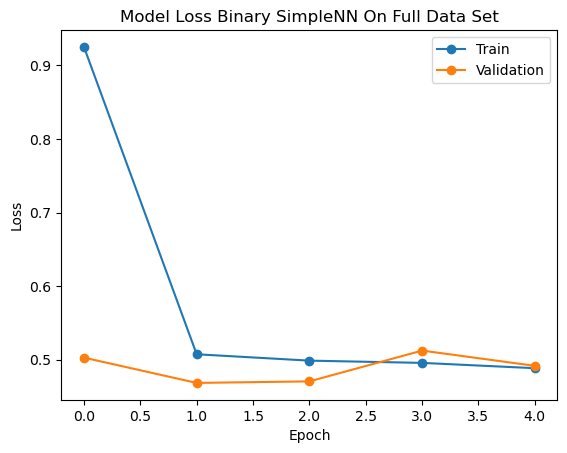

In [203]:
# Plotting loss function 
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss Binary SimpleNN On Full Data Set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Looking at the loss function however, we see that the validation set did not seem to improve having already started low in loss and remained the same. Training on the other hand started with a higher loss score and went down after the first epoch. 

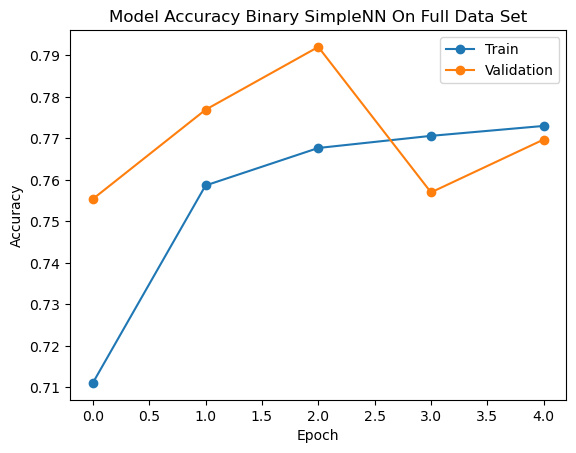

In [204]:
# Plotting accuracy function 
plt.plot(history.history['binary_accuracy'], marker='o')
plt.plot(history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy Binary SimpleNN On Full Data Set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

The accuracy also seems to have fluctuated a bit for validation while training showed a slow but steady improvement over epochs. Let's look into the classification report. 

In [208]:
# Get predicted target for training and testing set
y_pred_train = (model3.predict(binned_X_train) > 0.5).astype(int).reshape(-1)
y_pred_test = (model3.predict(binned_X_test) > 0.5).astype(int).reshape(-1)

In [211]:
# Classification report
cr = classification_report(y_train, y_pred_train)
print("Binary training classification report:")
print(cr)
cr = classification_report(y_test, y_pred_test)
print("Binary testing classification report:")
print(cr)

Binary training classification report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      6916
           1       0.75      0.76      0.75      5625

    accuracy                           0.78     12541
   macro avg       0.77      0.77      0.77     12541
weighted avg       0.78      0.78      0.78     12541

Binary testing classification report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1729
           1       0.77      0.76      0.76      1407

    accuracy                           0.79      3136
   macro avg       0.79      0.78      0.78      3136
weighted avg       0.79      0.79      0.79      3136



We see that the recall score for `ABNO` results on the test set seems to have the highest score. This is a decent model as it is able to capture differences in `NORM` vs `ABNO` ECGs allowing for early detection to people that may be at risk. 

#### Confusion Matrix

Another representation of the metrics above is given by the confusion matrix. 

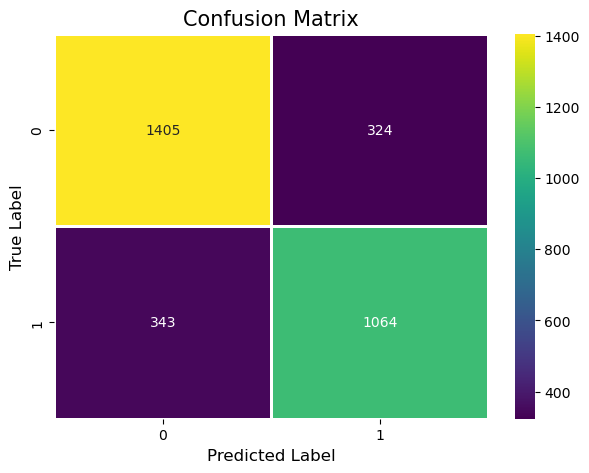

In [212]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Calculate the predicted labels for each test image.
predict_probas = model3.predict(binned_X_test)
y_predict = (predict_probas > 0.5).astype(int).reshape(-1)

# Create the confusion matrix using sklearn 
conf_mat = confusion_matrix(y_test, y_predict)

# Visualizing confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

Seeing that we are also classifying a lot of `NORM` signals as `NORM` and `ABNO` as `ABNO` is a good model. Lastly, we will look into the ROC curve and AUC score.

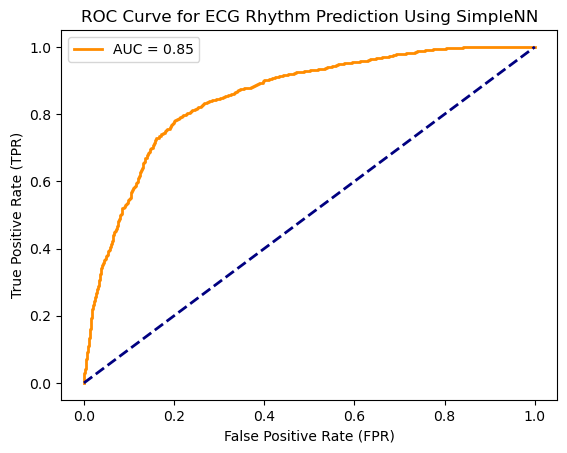

Area under curve (AUC):0.8530174049195484


In [214]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 0])
roc_auc = roc_auc_score(y_test, predict_probas[:, 0])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using SimpleNN')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')

Given our AUC score of ~85%, this means that we are 85% confident of classifying normal ECGs as `NORM` and abnormal ECGs as `ABNO`. 

Overall using our full dataset on our binary classification simple neural network has given us good results. Accuracy scores show values close to 80% with good recall score for the `ABNO` class (class 0). 

In the next, notebook `4 - Autoencoders` we look at how autoencoders can reconstruct our ECG signals. 